In [1]:
import statistics
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.transforms as T
import torch.optim as optim

from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import numpy as np

# Un problema real

Fins ara, heu treballat amb problemes de *machine learning* molt simples, fent ús de dades tabulars, com ara fitxers amb taules de valors numèrics o categories. Això us ha permès aprendre les bases del procés de preparació de dades, la creació de models senzills i la seva avaluació.

En aquesta pràctica, però, fareu un pas més enllà: per primer cop, treballareu amb dades en format d’imatges. Això suposarà un repte addicional, ja que les imatges són dades molt més complexes i necessiten tècniques especialitzades per ser tractades correctament. Aprendreu com carregar-les, quines són les millors pràctiques per treballar amb elles i com entrenar models de *deep learning* que siguin capaços de reconèixer patrons visuals.

## Lectura de dades

La primera passa d’aquesta pràctica consisteix en la càrrega de les dades. Per simplificar aquest procés, utilitzarem un ``DataLoader`` per defecte de PyTorch. Aquest DataLoader us permetrà carregar les imatges de forma eficient, dividir-les en lots (batches) i aplicar transformacions bàsiques abans de passar-les al model. Això us estalviarà temps i us permetrà centrar-vos en altres aspectes del desenvolupament del model, com la seva construcció i entrenament. A més, el DataLoader gestionarà automàticament la barreja (shuffling) de les dades, la qual cosa és molt important per assegurar un entrenament correcte.


Per aquesta pràctica, utilitzarem el conjunt de dades MNIST, que és un dels datasets més coneguts i utilitzats en el camp del machine learning. Aquest conjunt de dades conté imatges en escala de grisos de 28x28 píxels, cadascuna corresponent a un dígit escrit a mà, de l'0 al 9.

En aquesta pràctica específica, us centrareu en un problema de classificació binària. Això vol dir que triareu un nombre concret (per exemple, el dígit "3") i l'objectiu serà entrenar un model que sigui capaç de diferenciar entre aquest nombre i la resta de dígits. Així, el model haurà de predir si una imatge correspon al dígit seleccionat o si pertany a qualsevol altre nombre. Aquest enfocament us permetrà simplificar el problema inicialment i centrar-vos en comprendre el funcionament dels models de classificació aplicats a imatges

In [2]:
DOWNLOAD = False
BATCH_SIZE = 64
EPOCHS = 5

In [3]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)), # mitjana, desviacio tipica
])


train = datasets.MNIST("../data", train=True, download=DOWNLOAD, transform=transform)
test = datasets.MNIST("../data", train=False, download=DOWNLOAD, transform=transform)

train_loader = torch.utils.data.DataLoader(train, BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test, BATCH_SIZE)

Una bona pràctica es conèixer com són les dades que llegirem. Per fer-ho podem fer ús de la funció shape i les visualitzacions pròpies de ``Matplotlib``.

In [39]:
img, target = next(iter(train_loader))
print(img.shape, target.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


Quan carreguem les imatges amb el DataLoader de PyTorch, observareu que la seva forma (shape) es representa amb quatre dimensions, habitualment en el format: (batch_size, channels, height, width).

Aquestes dimensions són necessàries per tal de poder processar les imatges correctament en lots i gestionar-ne el format. A continuació, es detallen aquestes quatre dimensions:

- ``batch_size``: Aquesta dimensió indica el nombre d'imatges que es processen a la vegada en un sol lot (batch). Treballar amb lots permet que el model es pugui entrenar més ràpidament i de forma més estable, ja que es calculen les pèrdues (loss) i les actualitzacions de paràmetres per cada lot en lloc de fer-ho per cada imatge de forma individual.

- ``channels``: Aquest valor representa el nombre de canals de color de les imatges. En el cas del conjunt de dades MNIST, les imatges són en escala de grisos, de manera que només tenen un sol canal (channels=1). Si treballéssim amb imatges a color, com les RGB, aquest valor seria 3 (corresponent als canals de vermell, verd i blau).

- ``height`` i ``width``: Aquestes dimensions representen l'alçada i l'amplada de cada imatge. Com que les imatges del conjunt de dades MNIST tenen una mida de 28x28 píxels, els valors de height i width seran tots dos iguals a 28.

Així, la forma d’una mostra d'imatges MNIST carregada amb el DataLoader podria ser, per exemple, (64, 1, 28, 28), on 64 és la mida del lot (batch_size), 1 és el nombre de canals (escala de grisos), i 28x28 és la mida de cada imatge. Aquesta estructura és fonamental perquè els models de xarxes neuronals convolucionals (CNN) puguin processar les imatges de manera adequada.

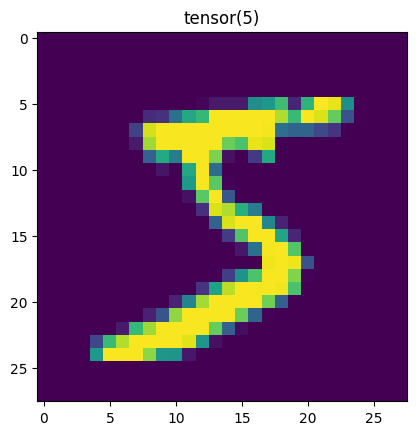

In [37]:
plt.imshow(img[0, 0])
plt.title(target[0]);

## Definició de la xarxa

In [8]:
model = nn.Sequential(
            torch.nn.Linear(784, 10),
            nn.ReLU(),
            torch.nn.Linear(10, 10),
            nn.ReLU(),
            torch.nn.Linear(10, 1)
        )

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(0))
model.to(device)

cuda
NVIDIA GeForce RTX 4080 SUPER


Sequential(
  (0): Linear(in_features=784, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=1, bias=True)
)

## Entrenament

L'entrenament es duu a terme en forma de bucle, i el nombre de vegades que cal repetir aquest bucle s'anomena ``epochs``, un hiperparàmetre que vosaltres haureu de decidir. Cada epoch implica que el model ha vist totes les dades de l'entrenament una vegada, però aquestes es processen en lots més petits, anomenats ``batches``. Això permet que el model pugui entrenar-se de manera més eficient i amb menys ús de memòria.

A cada iteració de l'entrenament (és a dir, per cada ``epoch``), la xarxa fa una predicció sobre tots els ``batches`` de dades disponible. Per cada ``batch``, es calcula l'error mitjà de totes les seves mostres d'aquest batch utilitzant una funció de pèrdua. Aquest error serveix per ajustar els pesos de la xarxa de manera que les futures prediccions siguin més precises. Aquest procés es repeteix per tots els ``batches`` i durant el nombre d’``epochs`` que hagueu definit, amb l'objectiu de millorar els resultats finals del model.

Com que el problema que estem abordant és de classificació binària, utilitzarem la funció de pèrdua [``BCEWithLogitsLoss``](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) de PyTorch. Aquesta funció és especialment adequada per a aquest tipus de tasques, ja que combina dues operacions en una de sola: la binary cross entropy (BCE) i l'aplicació de la funció sigmoide.

- Funció sigmoide: La funció sigmoide és una funció d'activació que transforma les prediccions de la xarxa en valors entre 0 i 1, el que és ideal per a la classificació binària, ja que podem interpretar aquestes sortides com probabilitats. Per exemple, si la sortida és propera a 1, la xarxa és més segura que la mostra pertany a la classe objectiu, mentre que si és propera a 0, indica que probablement no hi pertany.

- Binary Cross Entropy (BCE): La binary cross entropy mesura la diferència entre les prediccions de la xarxa (després de l'aplicació de la sigmoide) i les etiquetes reals de les dades. Això ens permet quantificar el grau d'error en cada predicció, assignant un valor de pèrdua més alt com més diferència hi hagi entre la probabilitat predita i la classe real.

La funció ``BCEWithLogitsLoss`` integra aquestes dues operacions en un sol pas, la qual cosa és més eficient tant a nivell computacional com numèricament estable. Així, no és necessari aplicar la funció sigmoide per separat abans de calcular la pèrdua. En resum, emprant aquesta funció de pèrdua, podem assegurar que el model aprèn de forma òptima a distingir entre les dues classes del problema de classificació binària.


In [10]:
loss_fn = torch.nn.BCEWithLogitsLoss()    

learning_rate =  1e-3 # Hiperparàmetre

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model = model.to(device)

### Bucle d'entrenament

Per poder veure com avança l'entranment empram la llibreria [``tqdm``](https://tqdm.github.io/)

In [57]:
running_loss = []
running_acc = []

running_test_loss = []
running_test_acc = []

for t in tqdm(range(EPOCHS), desc="Êpoques"):
    batch_loss = 0
    batch_acc = 0
    
    # Iteram els batches.
    for i_batch, (x, y) in tqdm(enumerate(train_loader), desc=f"Batches (Època {t + 1})"): 
        model.train() # Posam el model a mode entranament.
        
        x = x.reshape(x.shape[0], -1) # Aplanam la imatge.
        
        optimizer.zero_grad()

        # 1. PREDICCIÓ
        # Passat endavant: calcula la y, fa la predicció passant x al model. 
        
        y_pred = model(x.to(device))

        # 2. CALCUL DE LA PÈRDUA
        # Computa la pèrdua: l'error de predicció vs el valor correcte
        # Es guarda la pèrdua en un array per futures visualitzacions
        
        y = y.to(device)
        y_binary = (y == 5)
        y_binary = y_binary.double()

        y_binary = y_binary.reshape(-1, 1)

        loss = loss_fn(y_pred, y_binary)

        #3. GRADIENT
        # Posa a 0 els gradients del model per poder fer la passa enrere
        model.zero_grad()

        # Passa enrere: calcula el gradient de la pèrdua respecte a tots els paràmetres del model. 
        # Internament, s'emmagatzemen els paràmetres de cada mòdul a Tensors amb el paràmetere requires_grad=True, d
        # de manera que aquesta crida calcularà gradients per tots els paràmetres del model.
        loss.backward()

        # Actualitza els pesos utilitzant l'algorisme d'actualització
        #4. OPTIMITZACIO
        with torch.no_grad():
            optimizer.step()

    
        # 5. EVALUAM EL MODEL
        model.eval() # Mode avaluació de la xarxa
        
        y_pred = model(x.to(device))
        y_pred_binary = (y_pred > 0.5).double()

        batch_loss += (loss_fn(y_pred, y_binary).detach())
        batch_acc += accuracy_score(y_pred_binary.detach().cpu().numpy(), y_binary.detach().cpu().numpy())

    running_loss.append(batch_loss / (i_batch + 1))
    running_acc.append(batch_acc / (i_batch + 1))


    batch_test_loss = 0
    batch_test_acc = 0
    
    for i_batch, (x, y) in enumerate(test_loader): 
        x = x.reshape(x.shape[0], -1) # Aplanam la imatge.
        
        y_binary = (y == 5)
        y_binary = y_binary.double()
        y_binary = y_binary.reshape(-1, 1)

        y_pred = model(x.to(device))
        y_pred_binary = (y_pred > 0.5).double()

        batch_test_loss += (loss_fn(y_pred, y_binary.to(device)).detach())
        acc = accuracy_score(y_pred_binary.detach().cpu().numpy(), y_binary.detach().cpu().numpy())
        batch_test_acc += acc
        

    running_test_loss.append(batch_test_loss / (i_batch + 1))
    running_test_acc.append(batch_test_acc / (i_batch + 1))


Êpoques:   0%|          | 0/5 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Batches (Època 2): 0it [00:00, ?it/s]

Batches (Època 3): 0it [00:00, ?it/s]

Batches (Època 4): 0it [00:00, ?it/s]

Batches (Època 5): 0it [00:00, ?it/s]

In [28]:
cpu_running_loss = [t.cpu() for t in running_loss]
cpu_running_test_loss = [t.cpu() for t in running_test_loss]

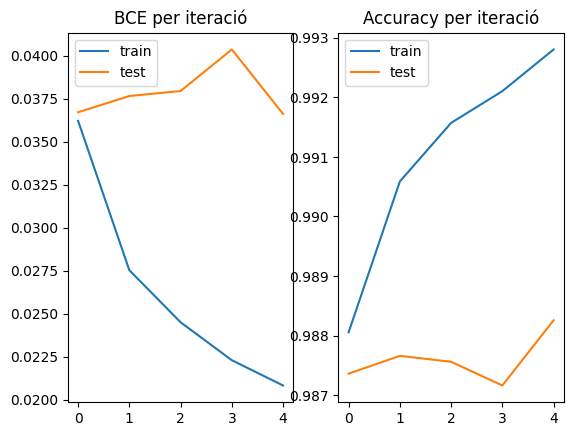

In [29]:
plt.subplot(1,2,1)
plt.title("BCE per iteració")
plt.plot(cpu_running_loss, label="train")
plt.plot(cpu_running_test_loss, label="test")
plt.legend()

plt.subplot(1,2,2)
plt.title("Accuracy per iteració")
plt.plot(running_acc, label="train")
plt.plot(running_test_acc, label="test")
plt.legend()
plt.show()

# Exercicis

1. Programa la avaluació del conjunt de test.
2. Prova noves configuracions de la xarxa afegint capes ocultes al model. Quina és la configuració que dona la millor classificació en el conjunt de test? i en el de test?
3. Hi ha ``overfitting``?
4. Prova diferents tasques: classifica diferents nombres. 1 vs la resta, 3 vs la resta.
5. Compara els diferents resultats.